In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-data-updated-till-28jun2021:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1436765%2F3358622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240722%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240722T213138Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D111e7feb1d990c7659038ca6ad1277e6eef2907cf37932a6ae24505e8101c85dd9757b40434d1374b3f11d62c14cbf08ab33bc29b939aae68431a911b63d9009070c05ce479ed6823b9470d906cd37abcf6a267826297ef7d5f3c6187071794d47d3751b04816c1541b315271fef2b94520248f8367c23e1486192eb8a5982a8b8995f90ca03ccefcf23239fb05d96ce7bf45c627931ea6690d60a6a98c424f02ae0c7a02d08387f0e8ea91382867c0cb21618f0ecac4e2b6e342fb26f3e779f2df6cf55d438429f96e48f78431e2b7d8b312e823648f399eca3b9539b8640b0bd5c54e356a5c17bdf322b84202d65d3a1739143cb06f40052e38fdd9bfa7469'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 60051 bytes downloaded
Downloaded and uncompressed: tesla-stock-data-updated-till-28jun2021
Data source import complete.


# Import Necessary Library

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta


from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reading the Data

In [3]:
df = pd.read_csv('/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv', parse_dates= True , index_col= "Date")
dfforVisualization = pd.read_csv('/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv')

**Used parse date to make column data to datetime datatype to handle this date becouse i treat with timeseries data**

# Explore the Data

In [4]:
df.shape

(2956, 6)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


**from data we can see we have 6 column to determine when the Stock start and end and the volume**

In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


**We can see this data from 2010 to 2022**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [9]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df.duplicated().sum()

0

# Analysis and Visualizations

In [11]:
dfforVisualization

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [12]:
dfforVisualization['Date'] = pd.to_datetime(dfforVisualization['Date'])

**Make column year to show the volume for each year**

In [13]:
dfforVisualization['Year'] = dfforVisualization['Date'].dt.year

In [14]:
dfforVisualization = dfforVisualization[['Year', 'Volume']].groupby('Year').agg({
    'Volume': ['sum']}).reset_index()

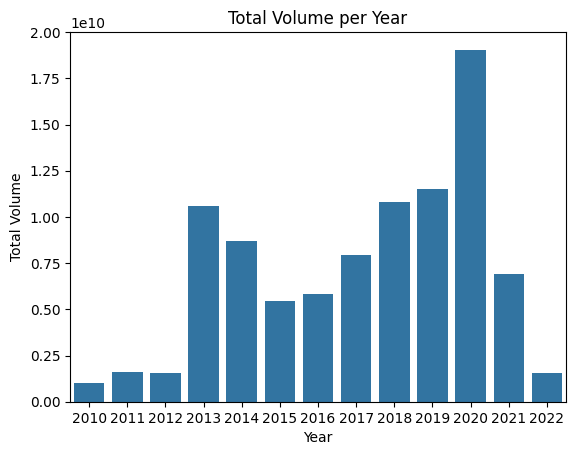

In [34]:
dfforVisualization.columns = ['Year', 'Total Volume']
sns.barplot(x='Year', y='Total Volume', data=dfforVisualization)

# Add title and labels
plt.title('Total Volume per Year')
plt.xlabel('Year')
plt.ylabel('Total Volume')

# Show the plot
plt.show()

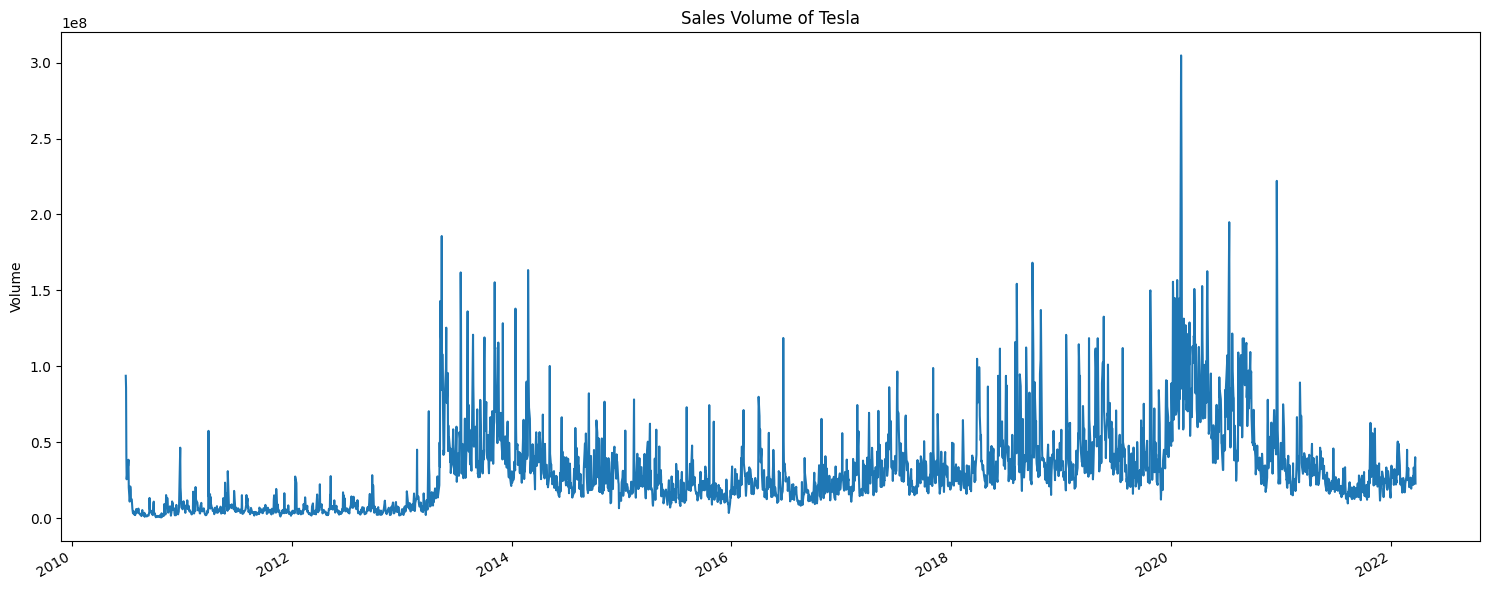

In [35]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

In [36]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


<h2>Open and Close<h2>

In [37]:
open_close = df[['Open','Close']]

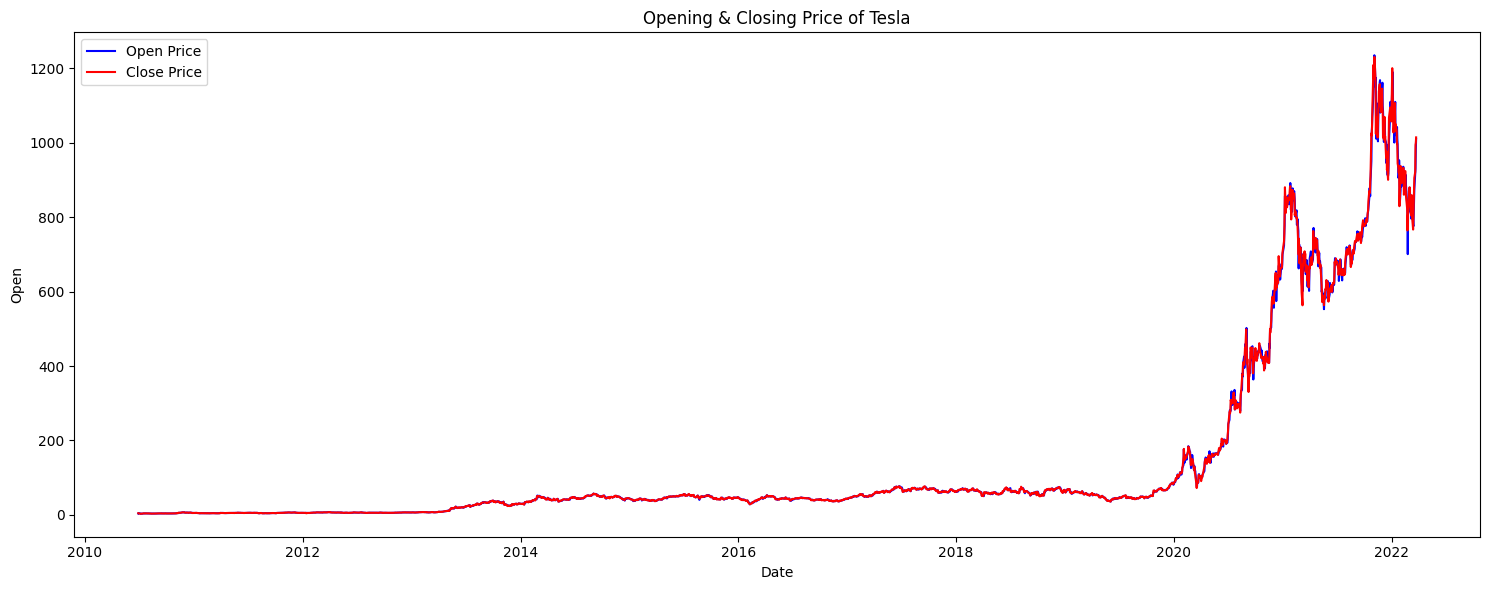

In [38]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=open_close, x='Date', y='Open', label='Open Price', color='blue')
sns.lineplot(data=open_close, x='Date', y='Close', label='Close Price', color='red')

plt.title("Opening & Closing Price of Tesla")
plt.legend()
plt.tight_layout()
plt.show()

<h2>High and Low<h2>

In [39]:
high_low = df[['High','Low']]

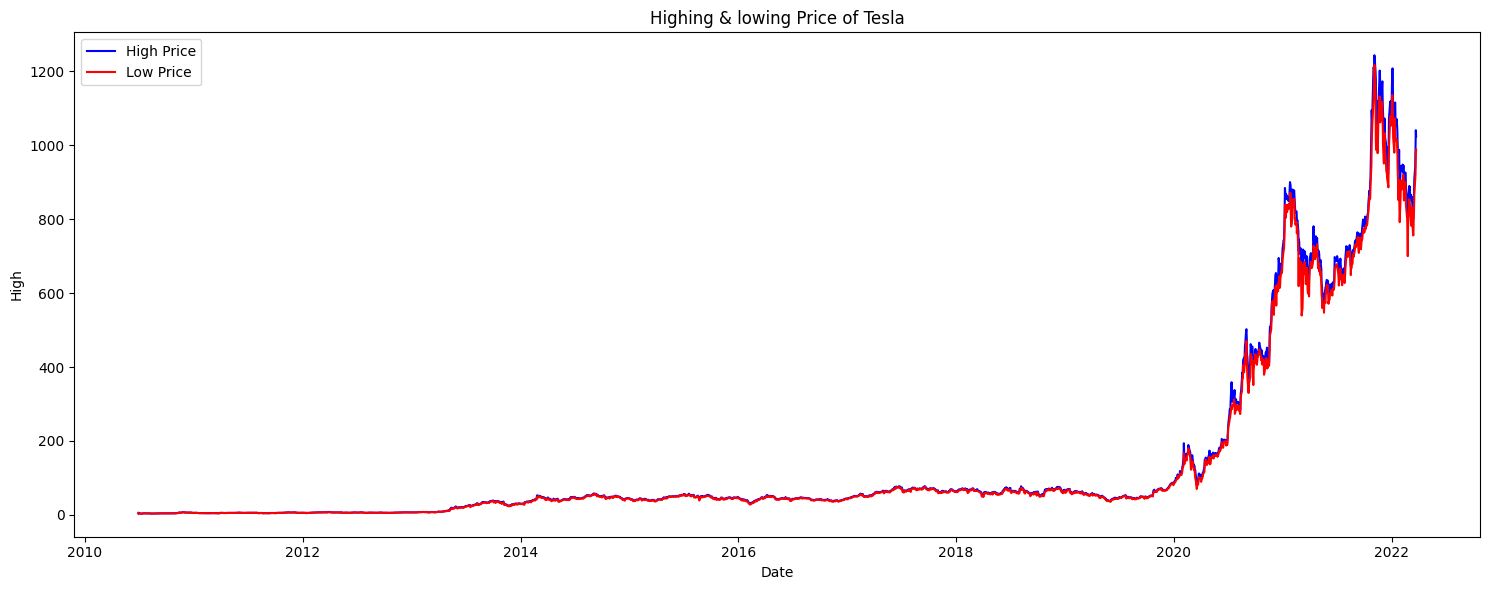

In [40]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=high_low, x='Date', y='High', label='High Price', color='blue')
sns.lineplot(data=high_low, x='Date', y='Low', label='Low Price', color='red')

plt.title("Highing & lowing Price of Tesla")
plt.legend()
plt.tight_layout()
plt.show()

# Data Preprocessing

**Choosing Prediction Column**

In [41]:
dataset = df['Close']
dataset = pd.DataFrame(dataset)
dataset

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


In [42]:
dataset.shape

(2956, 1)

**Normalizing Data**

In [43]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(dataset)

In [44]:
scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.80767879],
       [0.81186057],
       [0.82393312]])

# Spliting the Data

In [45]:
train_size = int(len(dataset)*.75)
test_size = len(dataset) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 2217 Test Size : 739


In [46]:
train_data.shape

(2217, 1)

In [47]:
test_data.shape

(799, 1)

**Creating training set**

In [48]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [49]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [50]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [51]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

In [53]:
x_train

array([[[1.31893210e-03],
        [1.30915016e-03],
        [1.00427957e-03],
        ...,
        [8.57550414e-04],
        [8.10271019e-04],
        [6.63541861e-04]],

       [[1.30915016e-03],
        [1.00427957e-03],
        [5.54310154e-04],
        ...,
        [8.10271019e-04],
        [6.63541861e-04],
        [6.13001817e-04]],

       [[1.00427957e-03],
        [5.54310154e-04],
        [5.05400434e-05],
        ...,
        [6.63541861e-04],
        [6.13001817e-04],
        [7.01039312e-04]],

       ...,

       [[4.67022608e-02],
        [4.61577326e-02],
        [4.43105771e-02],
        ...,
        [4.11852428e-02],
        [4.10678619e-02],
        [4.08526591e-02]],

       [[4.61577326e-02],
        [4.43105771e-02],
        [4.49496609e-02],
        ...,
        [4.10678619e-02],
        [4.08526591e-02],
        [4.19906253e-02]],

       [[4.43105771e-02],
        [4.49496609e-02],
        [4.58512325e-02],
        ...,
        [4.08526591e-02],
        [4.1990

In [54]:
y_train

array([0.000613  , 0.00070104, 0.00077114, ..., 0.04199063, 0.04164336,
       0.04197432])

Implemeting the LSTM model

In [56]:
model = Sequential([
    LSTM(50,return_sequences= True, input_shape =(x_train.shape[1],1) ),
    LSTM(64,return_sequences=False),
         Dense(32),
         Dense(16),
        Dense(1)
                    ])
model.compile(optimizer ='adam',loss = 'mse')


In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
callbacks = [EarlyStopping(monitor = 'loss', patience = 10,restore_best_weights= True)]
history = model.fit(x_train,y_train,epochs = 50 , batch_size =32,callbacks = callbacks)

Epoch 1/50
68/68 [==============================] - 12s 60ms/step - loss: 1.1592e-04
Epoch 2/50
68/68 [==============================] - 4s 63ms/step - loss: 6.4531e-06
Epoch 3/50
68/68 [==============================] - 5s 77ms/step - loss: 5.3064e-06
Epoch 4/50
68/68 [==============================] - 4s 60ms/step - loss: 5.8702e-06
Epoch 5/50
68/68 [==============================] - 4s 61ms/step - loss: 5.4809e-06
Epoch 6/50
68/68 [==============================] - 5s 80ms/step - loss: 4.8842e-06
Epoch 7/50
68/68 [==============================] - 5s 70ms/step - loss: 4.4787e-06
Epoch 8/50
68/68 [==============================] - 4s 64ms/step - loss: 5.6085e-06
Epoch 9/50
68/68 [==============================] - 5s 77ms/step - loss: 4.9110e-06
Epoch 10/50
68/68 [==============================] - 6s 83ms/step - loss: 3.8424e-06
Epoch 11/50
68/68 [==============================] - 5s 80ms/step - loss: 4.3050e-06
Epoch 12/50
68/68 [==============================] - 4s 64ms/step - loss:

**Model Evaluation**

In [86]:
x_test =[]
y_test = []

for i in range(60,len(test_data)):
  x_test.append(test_data[i-50:i,0])
  y_test.append(test_data[i,0])

x_test,y_test = np.array(x_test),np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [87]:
x_test.shape

(739, 50, 1)

In [88]:
y_test.shape

(739,)

In [92]:
Prediction=model.predict(x_test)

24/24 [==============================] - 0s 18ms/step


In [93]:
Prediction.shape

(739, 1)

Convert the scaler data to original data

In [98]:
Prediction = scaler.inverse_transform(Prediction)

In [100]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean(y_test -Prediction)**2).round(2)
RMSE

32.11

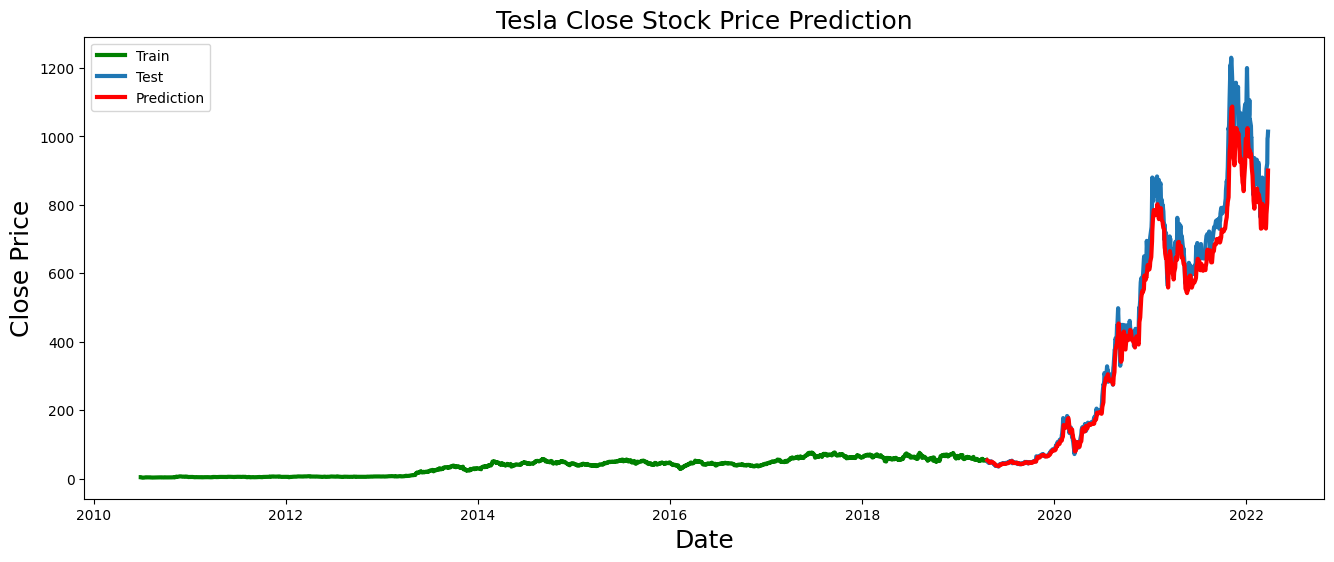

In [108]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Prediction'] = Prediction

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3,color = 'green')
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Prediction"], linewidth= 3,color ='red')
plt.legend(['Train', 'Test', 'Prediction'])